# Exploratory Analysis:

- Upload pickled tables
- Retain only synonymous changes SNPs
- Calculate the average phyloP and PhastCons for every codon change
- Calculate the frequency of each codon change
- Calculate the Spearman correlation between the phyloP (or PhastCons) and the frequency

##### TODO's
1. Double check if tables is properly parsing `NA` data.
2. Remove synonymous sites that are in exon-intron junctions (use the `custom_annotation` column);
3. Remove sites with partial codon sequences (I saw some in Zambia);

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from exploratory_analyses import *

In [2]:
# Unpickling a DataFrame
%cd ../results/tables/

with open('dgrp2_rooted_table.pkl', 'rb') as file:
    dgrp2_combined_df = pickle.load(file)


with open('dpgp3_rooted_table.pkl', 'rb') as file:
    dpgp3_combined_df = pickle.load(file)

/Users/vitorpavinato/Library/Caches/pypoetry/virtualenvs/prf-ratios-syn-jaLkkU1r-py3.12/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/vitorpavinato/WorkDir/PRF_Ratios_syn/results/tables


In [3]:
# Making the values explicitly float for phyloP and PhastCons scores
dgrp2_combined_df['phyloP'] = pd.to_numeric(dgrp2_combined_df['phyloP'], errors='coerce')
dgrp2_combined_df['phastCons'] = pd.to_numeric(dgrp2_combined_df['phastCons'], errors='coerce')
# print(dgrp2_combined_df.dtypes)

dpgp3_combined_df['phyloP'] = pd.to_numeric(dpgp3_combined_df['phyloP'], errors='coerce')
dpgp3_combined_df['phastCons'] = pd.to_numeric(dpgp3_combined_df['phastCons'], errors='coerce')
# print(dpgp3_combined_df.dtypes)

In [4]:
# Filter for synonymous mutations
dgrp2_synonymous_df = dgrp2_combined_df[dgrp2_combined_df['maineffect'] == 'SYNONYMOUS_CODING']

dpgp3_synonymous_df = dpgp3_combined_df[dpgp3_combined_df['maineffect'] == 'SYNONYMOUS_CODING']

In [5]:
# Create codon change statistics dictionaries
dgrp2_codon_stats = create_codon_stats(dgrp2_synonymous_df, use_filter=True, phylop_col='phyloP', phastcons_col='phastCons', custom_annotation_col='custom_annotation')

dpgp3_codon_stats = create_codon_stats(dpgp3_synonymous_df, use_filter=True, phylop_col='phyloP', phastcons_col='phastCons', custom_annotation_col='custom_annotation')

In [6]:
# Create the dataframes from the dictionary
dgrp2_stats = create_codon_stats_dataframe(dgrp2_codon_stats)

dpgp3_stats = create_codon_stats_dataframe(dpgp3_codon_stats)

In [7]:
print(f"shape of dgrp2_stats: {dgrp2_stats.shape} and \n shape of dpgp3_stats: {dpgp3_stats.shape}")

shape of dgrp2_stats: (134, 4) and 
 shape of dpgp3_stats: (134, 4)


In [8]:
# Export the data
dgrp2_stats.to_csv('../exploratory/dgrp2_synonymous_stats_.csv', index=False)

dpgp3_stats.to_csv('../exploratory/dpgp3_synonymous_stats_.csv', index=False)

In [9]:
dgrp2_stats.head()

,codon_change,mean_phyloP,mean_phastCons,count
0,TTT->TTC,0.451233,0.839734,2110
1,TTC->TTT,0.432181,0.902638,10273
2,CTT->CTC,-0.630100,0.642978,1107
3,CTC->CTT,-0.581766,0.763587,5205
4,CTT->CTA,-0.563292,0.655207,900


In [13]:
def plot_xvar_vs_yvars(
        dt: DataFrame,
        xvar_col: str,
        y1var_col: str,
        y2var_col: str,
        name: str) -> dict:
    """
    Calculate Spearman Correlation and return
    the plot for PhyloP and phastCons scores.
    """

    # Calculate Spearman's rank correlation
    correlation_y1var, p_value_y1var = stats.spearmanr(dt[xvar_col], dt[y1var_col])
    correlation_y2var, p_value_y2var = stats.spearmanr(dt[xvar_col], dt[y2var_col])

    # Print correlation results
    print(f"Spearman's rank correlation coefficient {y1var_col}: {correlation_y1var}")
    print(f"P-value {y1var_col}: {p_value_y1var}")
    print(f"Spearman's rank correlation coefficient {y2var_col}: {correlation_y2var}")
    print(f"P-value {{y2var_col}}: {p_value_y2var}")

    # Create scatter plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # y1var plot
    sns.regplot(x=xvar_col, y=y1var_col, data=dt, ax=ax1)
    ax1.set_xlabel(f'{xvar_col}')
    ax1.set_ylabel(f'{y1var_col}')
    ax1.set_title(f'{xvar_col} vs {y1var_col}')

    # Add correlation info to phyloP plot
    ax1.annotate(f'Spearman r = {correlation_y1var:.3f}\np-value = {p_value_y1var:.3e}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 fontsize=12)

    # y2var plot
    sns.regplot(x=xvar_col, y=y2var_col, data=dt, ax=ax2)
    ax2.set_xlabel(f'{xvar_col}')
    ax2.set_ylabel(f'{y2var_col}')
    ax2.set_title(f'{xvar_col} vs {y2var_col}')

    # Add correlation info to phyloP plot
    ax2.annotate(f'Spearman r = {correlation_y2var:.3f}\np-value = {p_value_y2var:.3e}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 ha='left', va='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 fontsize=12)

    plt.tight_layout()

    # Generate timestamp for file names
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create directory if it doesn't exist
    os.makedirs('../exploratory', exist_ok=True)

    # Save the entire figure
    fig_path = f'../exploratory/{name}_{y1var_col}_{y2var_col}_{xvar_col}_{timestamp}.png'
    fig.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Combined plot saved as {fig_path}")

    # Show the plot
    plt.show()

    # Close the figure to free up memory
    plt.close(fig)

    # Return correlation results
    return {
        'y1var': {'correlation': correlation_y1var, 'p_value': p_value_y1var},
        'y2var': {'correlation': correlation_y2var, 'p_value': p_value_y2var}
    }

Spearman's rank correlation coefficient mean_phyloP: 0.3958487898273316
P-value mean_phyloP: 2.1991906601482994e-06
Spearman's rank correlation coefficient mean_phastCons: 0.6988976075818949
P-value {y2var_col}: 6.0153210683971075e-21
Combined plot saved as ../exploratory/dgrp2_mean_phyloP_mean_phastCons_count_20240703_074432.png


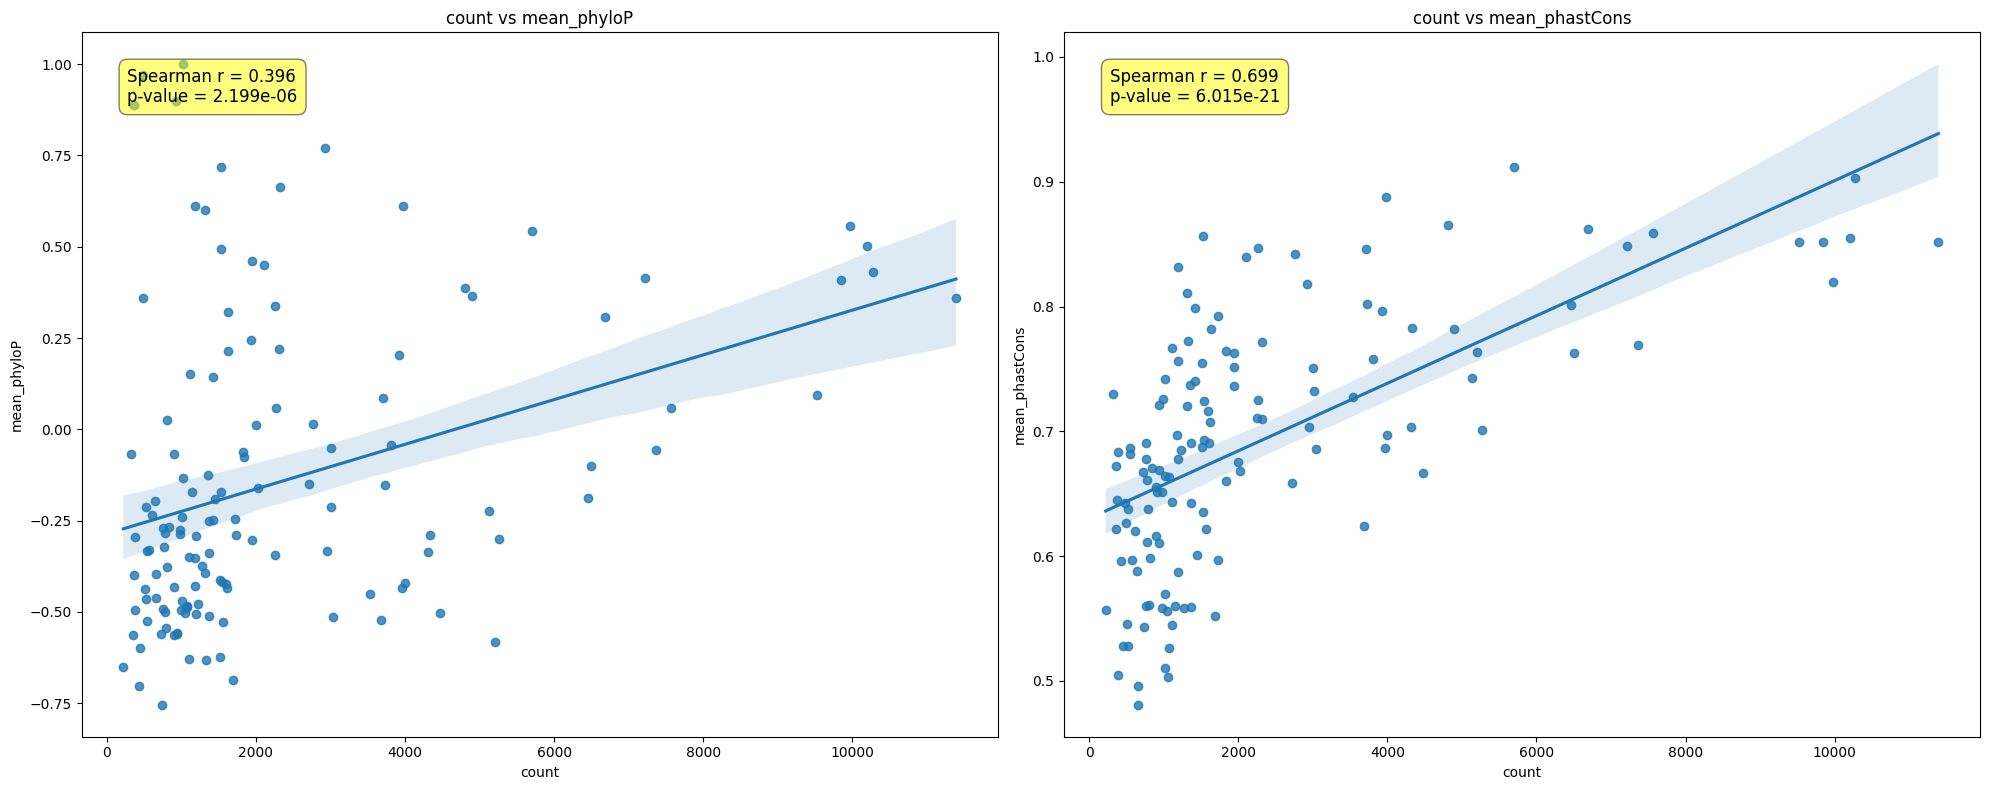

Spearman's rank correlation coefficient mean_phyloP: 0.4193792940061597
P-value mean_phyloP: 4.56634610718541e-07
Spearman's rank correlation coefficient mean_phastCons: 0.7049439519196001
P-value {y2var_col}: 1.9770578092033744e-21
Combined plot saved as ../exploratory/dpgp3_mean_phyloP_mean_phastCons_count_20240703_074433.png


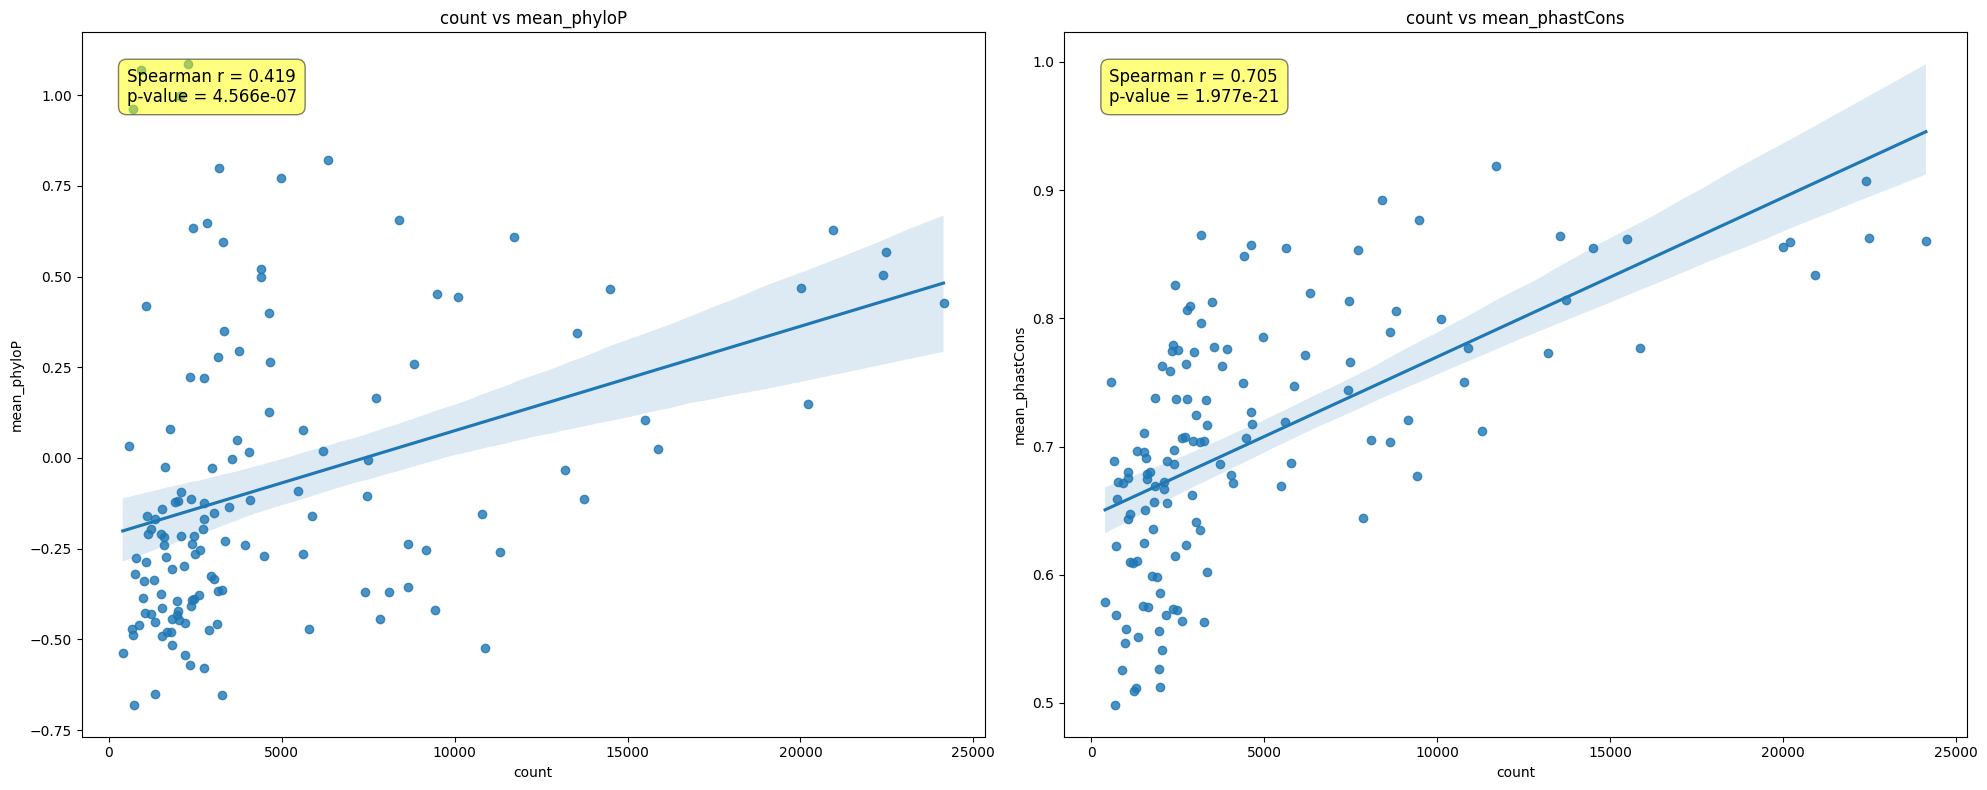

In [14]:
# Make correlation plots
dgrp2_correlation_results = plot_xvar_vs_yvars(dgrp2_stats, xvar_col='count', y1var_col='mean_phyloP', y2var_col='mean_phastCons', name='dgrp2')

dpgp3_correlation_results = plot_xvar_vs_yvars(dpgp3_stats, xvar_col='count', y1var_col='mean_phyloP', y2var_col='mean_phastCons', name='dpgp3')

In [15]:
# Sort the DataFrame by phyloP and phastCons scores
dgrp2_avg_phylop = dgrp2_stats.sort_values('mean_phyloP', ascending=False)
dgrp2_avg_phastcons = dgrp2_stats.sort_values('mean_phastCons', ascending=False)

# Sort the DataFrame by phyloP and phastCons scores
dpgp3_avg_phylop = dpgp3_stats.sort_values('mean_phyloP', ascending=False)
dpgp3_avg_phastcons = dpgp3_stats.sort_values('mean_phastCons', ascending=False)

Plot saved as ../exploratory/dgrp2_mean_phyloP_plot_20240703_074711.png


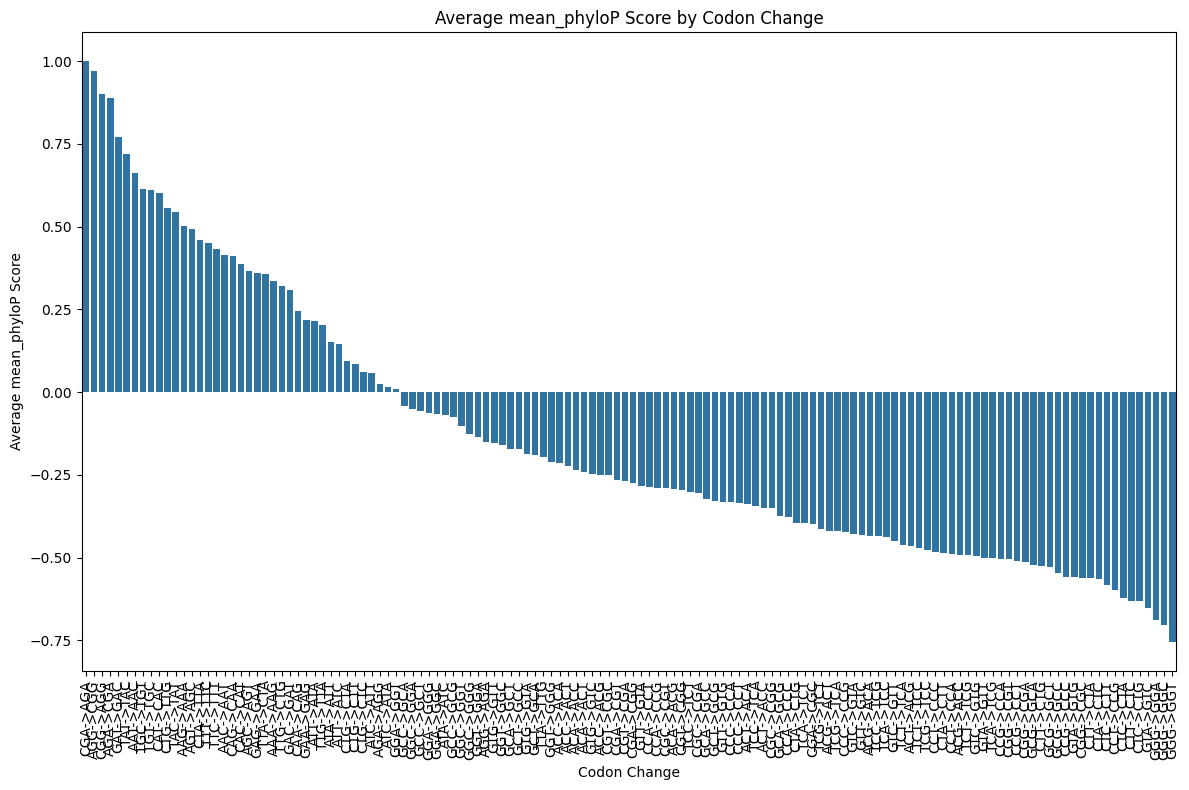

In [16]:
# Plot phyloP scores
plot_scores(dgrp2_avg_phylop, 'mean_phyloP', 'dgrp2')

Plot saved as ../exploratory/dgrp2_mean_phastCons_plot_20240703_074715.png


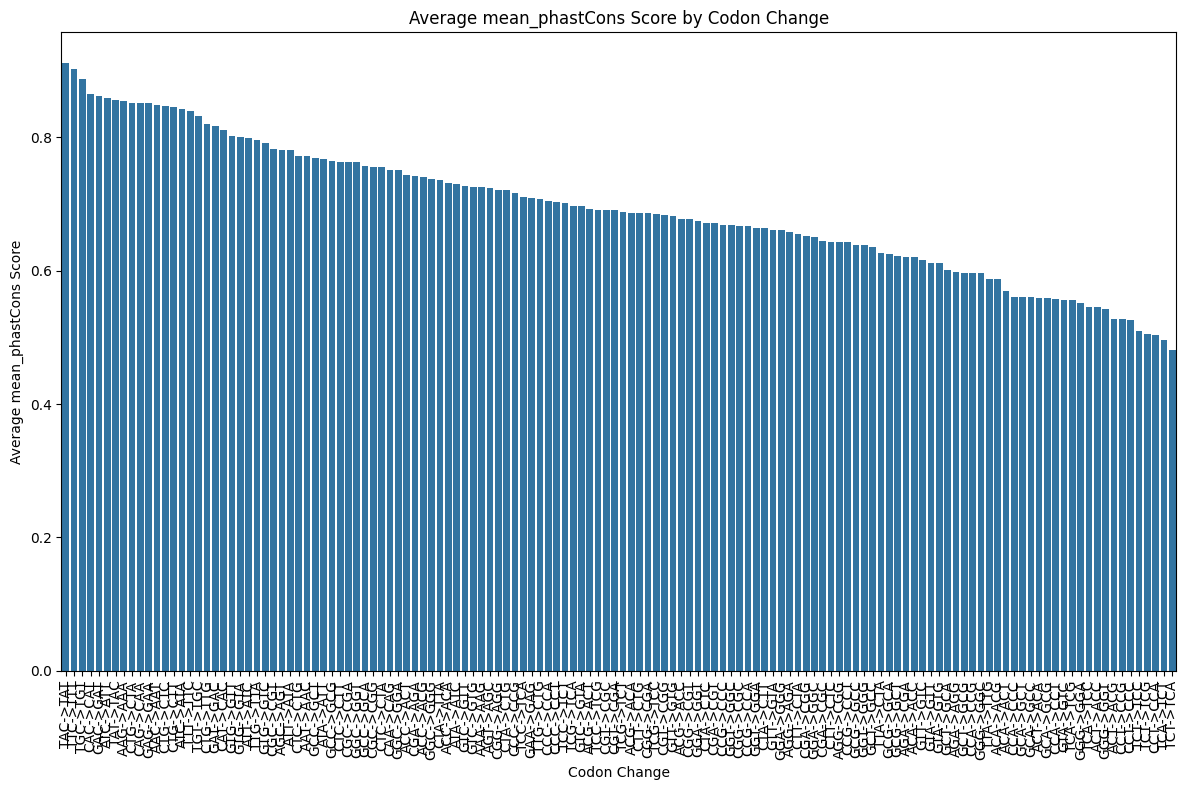

In [17]:
# Plot phastCons scores
plot_scores(dgrp2_avg_phastcons, 'mean_phastCons', 'dgrp2')

Plot saved as ../exploratory/dpgp3_mean_phyloP_plot_20240703_074720.png


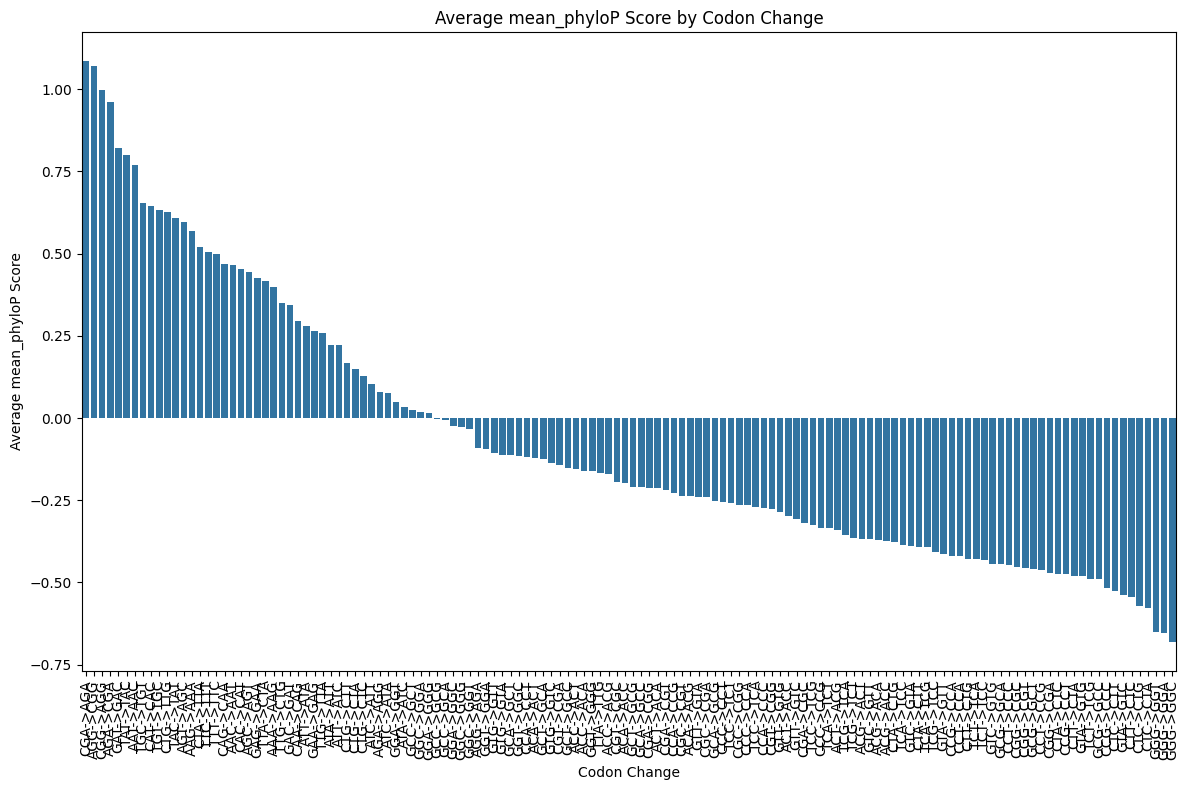

Plot saved as ../exploratory/dpgp3_mean_phastCons_plot_20240703_074721.png


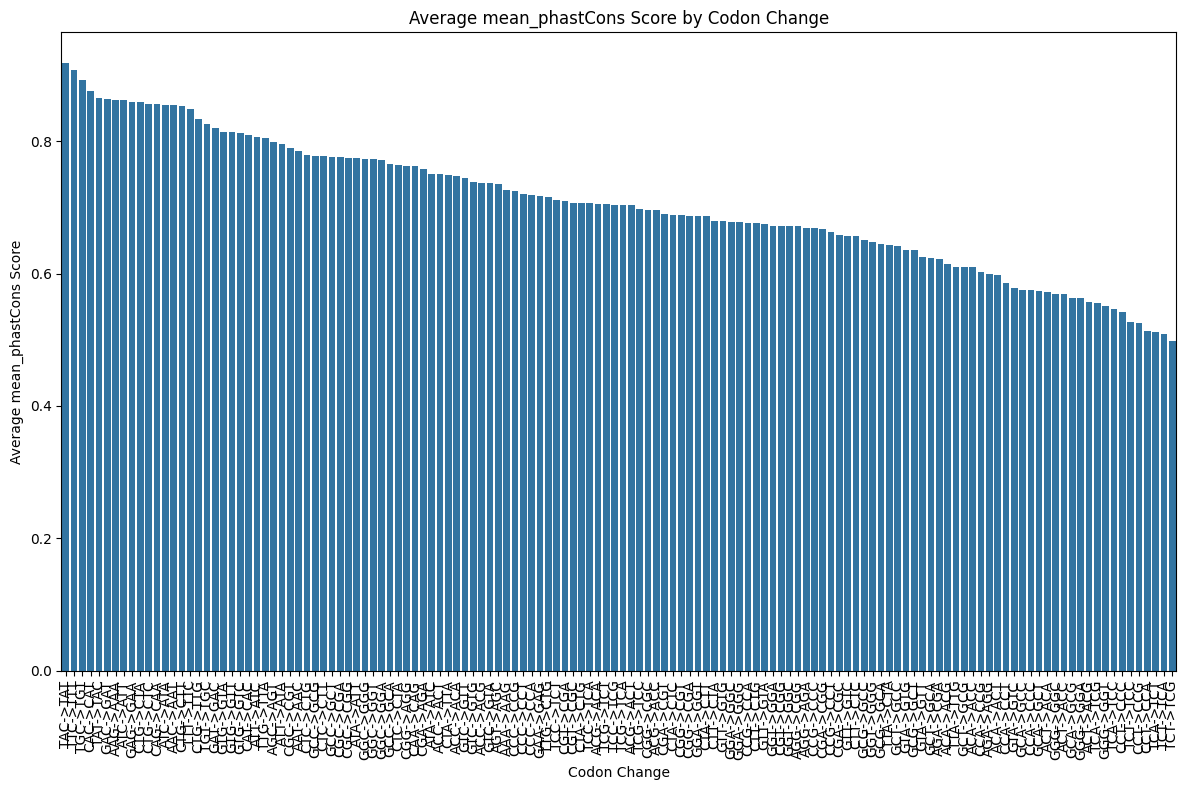

In [18]:
plot_scores(dpgp3_avg_phylop, 'mean_phyloP', 'dpgp3')
plot_scores(dpgp3_avg_phastcons, 'mean_phastCons', 'dpgp3')

#### Check SynREV correlation with phyloP or PhastCons

In [19]:
# Load SynREV derived data
%cd ../exploratory

synrev_means_df = pd.read_csv('means.csv')
synrev_medians_df = pd.read_csv('medians.csv')

/Users/vitorpavinato/WorkDir/PRF_Ratios_syn/results/exploratory


/Users/vitorpavinato/Library/Caches/pypoetry/virtualenvs/prf-ratios-syn-jaLkkU1r-py3.12/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [20]:
# Convert stats dataframes to dictionaries
dgrp2_stats_dict = create_mean_dict(dgrp2_stats)

dpgp3_stats_dict = create_mean_dict(dpgp3_stats)

In [21]:
# Normalize codon changes in synREV
synrev_means_dict = normalize_dataframe(synrev_means_df)

synrev_medians_dict = normalize_dataframe(synrev_medians_df)

In [23]:
# Combine the dictionaries and convert to DataFrame
dgrp2_synrev_means_df = combine_dicts(dgrp2_stats_dict, synrev_means_dict)

dpgp3_synrev_means_df = combine_dicts(dpgp3_stats_dict, synrev_means_dict)

Spearman's rank correlation coefficient mean_phyloP: 0.3167052438343045
P-value mean_phyloP: 0.009023925259774473
Spearman's rank correlation coefficient mean_phastCons: -0.006664538271210792
P-value {y2var_col}: 0.9573131603943991
Combined plot saved as ../exploratory/dgrp2_mean_phyloP_mean_phastCons_codon_rate_20240703_075014.png


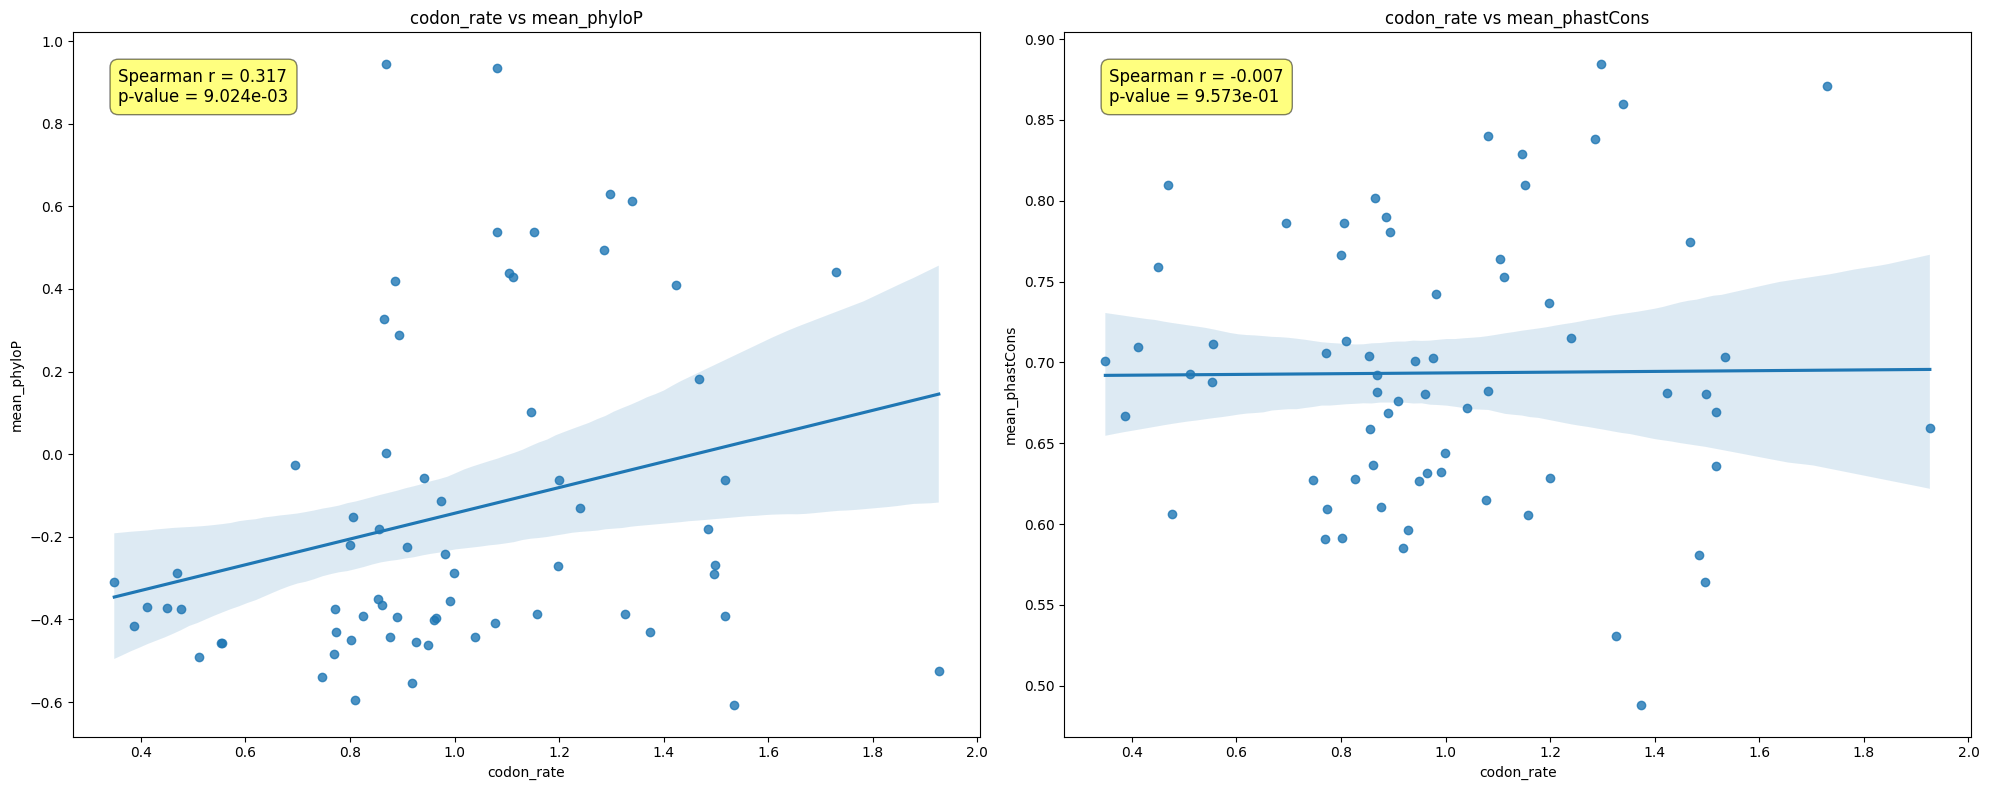

Spearman's rank correlation coefficient mean_phyloP: 0.30900311277835424
P-value mean_phyloP: 0.010949757576777014
Spearman's rank correlation coefficient mean_phastCons: 0.013927687764386626
P-value {y2var_col}: 0.9109320278809793
Combined plot saved as ../exploratory/dpgp3_mean_phyloP_mean_phastCons_codon_rate_20240703_075015.png


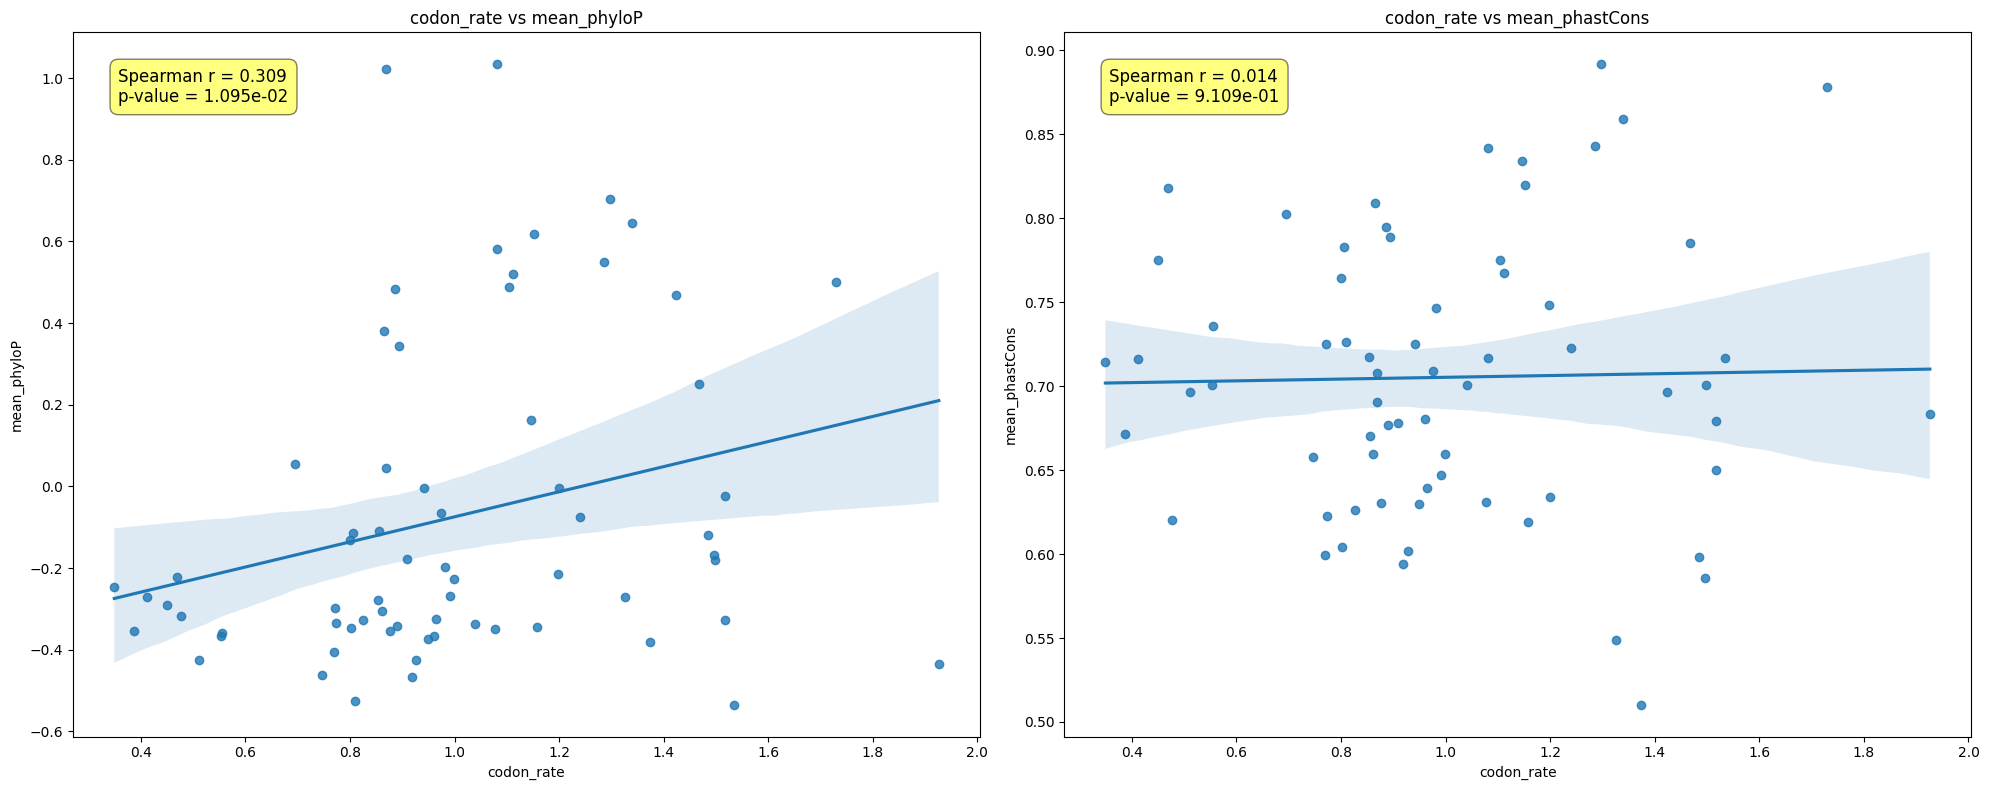

In [25]:
# Make correlation plots
dgrp2_correlation_synrev_results = plot_xvar_vs_yvars(dgrp2_synrev_means_df, xvar_col='codon_rate', y1var_col='mean_phyloP', y2var_col='mean_phastCons', name='dgrp2')

dpgp3_correlation_synrev_results = plot_xvar_vs_yvars(dpgp3_synrev_means_df, xvar_col='codon_rate', y1var_col='mean_phyloP', y2var_col='mean_phastCons', name='dpgp3')

In [28]:
# Combine the dictionaries and convert to DataFrame
dgrp2_synrev_medians_df = combine_dicts(dgrp2_stats_dict, synrev_medians_dict)

dpgp3_synrev_medians_df = combine_dicts(dpgp3_stats_dict, synrev_medians_dict)

Spearman's rank correlation coefficient mean_phyloP: 0.4638039747785139
P-value mean_phyloP: 7.718982053851373e-05
Spearman's rank correlation coefficient mean_phastCons: 0.22631494931758322
P-value {y2var_col}: 0.06553670825558074
Combined plot saved as ../exploratory/dgrp2_mean_phyloP_mean_phastCons_codon_rate_20240703_080830.png


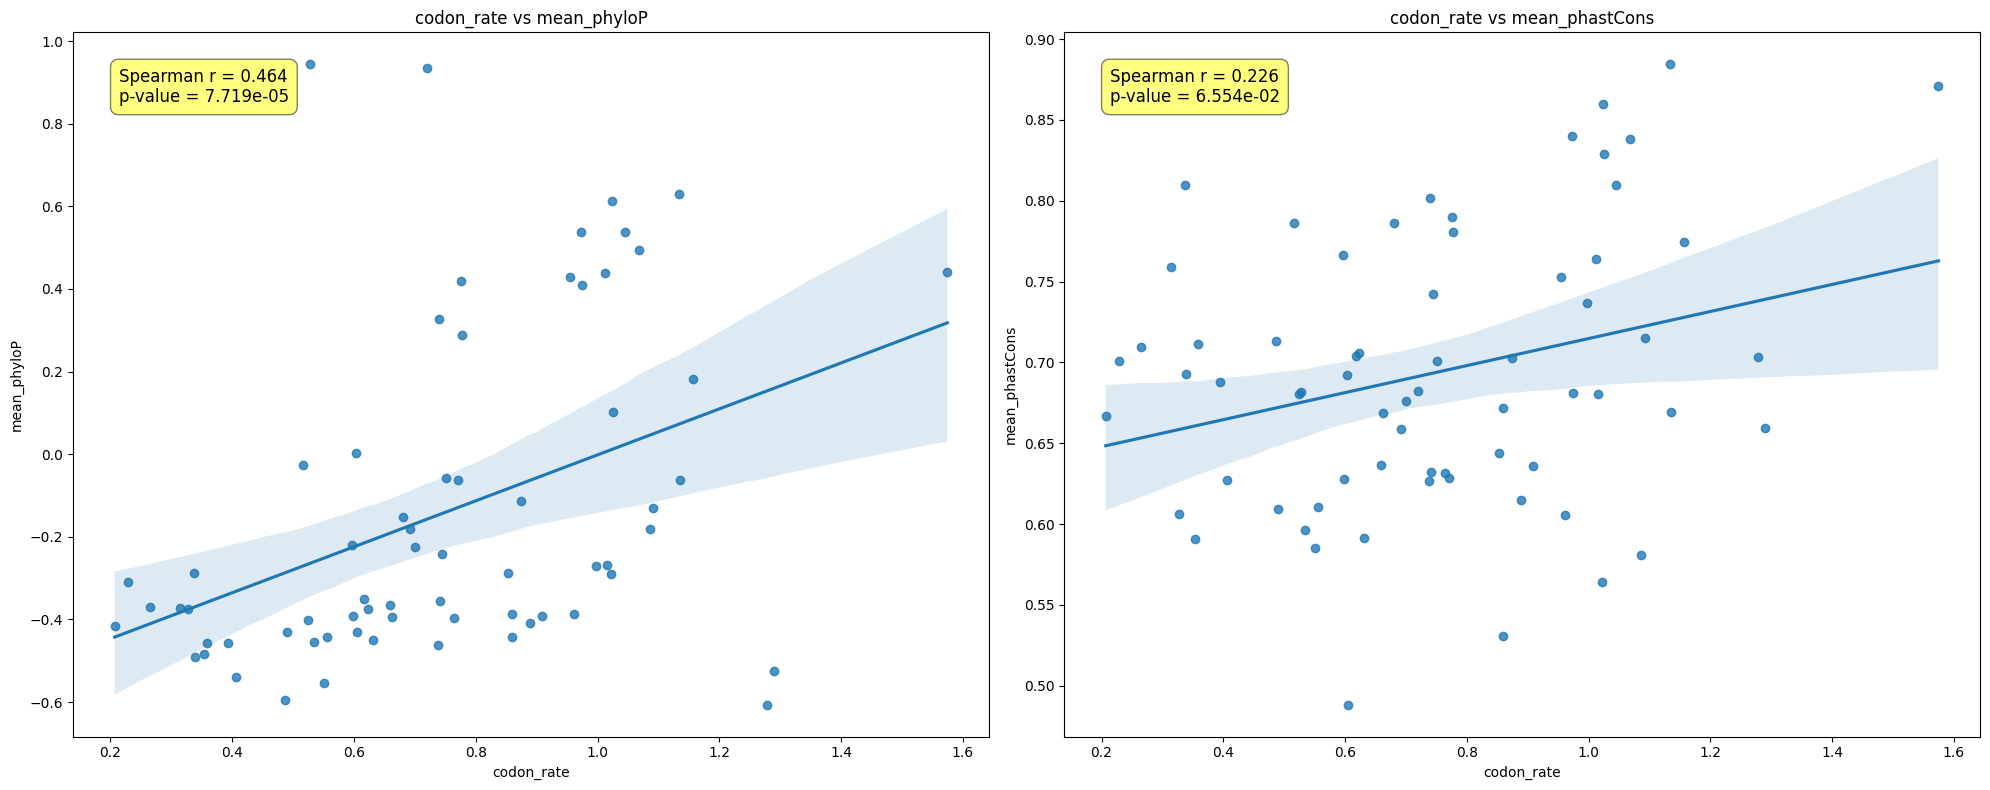

Spearman's rank correlation coefficient mean_phyloP: 0.46927129060579464
P-value mean_phyloP: 6.180113922034379e-05
Spearman's rank correlation coefficient mean_phastCons: 0.24734615691595502
P-value {y2var_col}: 0.04359241762961728
Combined plot saved as ../exploratory/dpgp3_mean_phyloP_mean_phastCons_codon_rate_20240703_080831.png


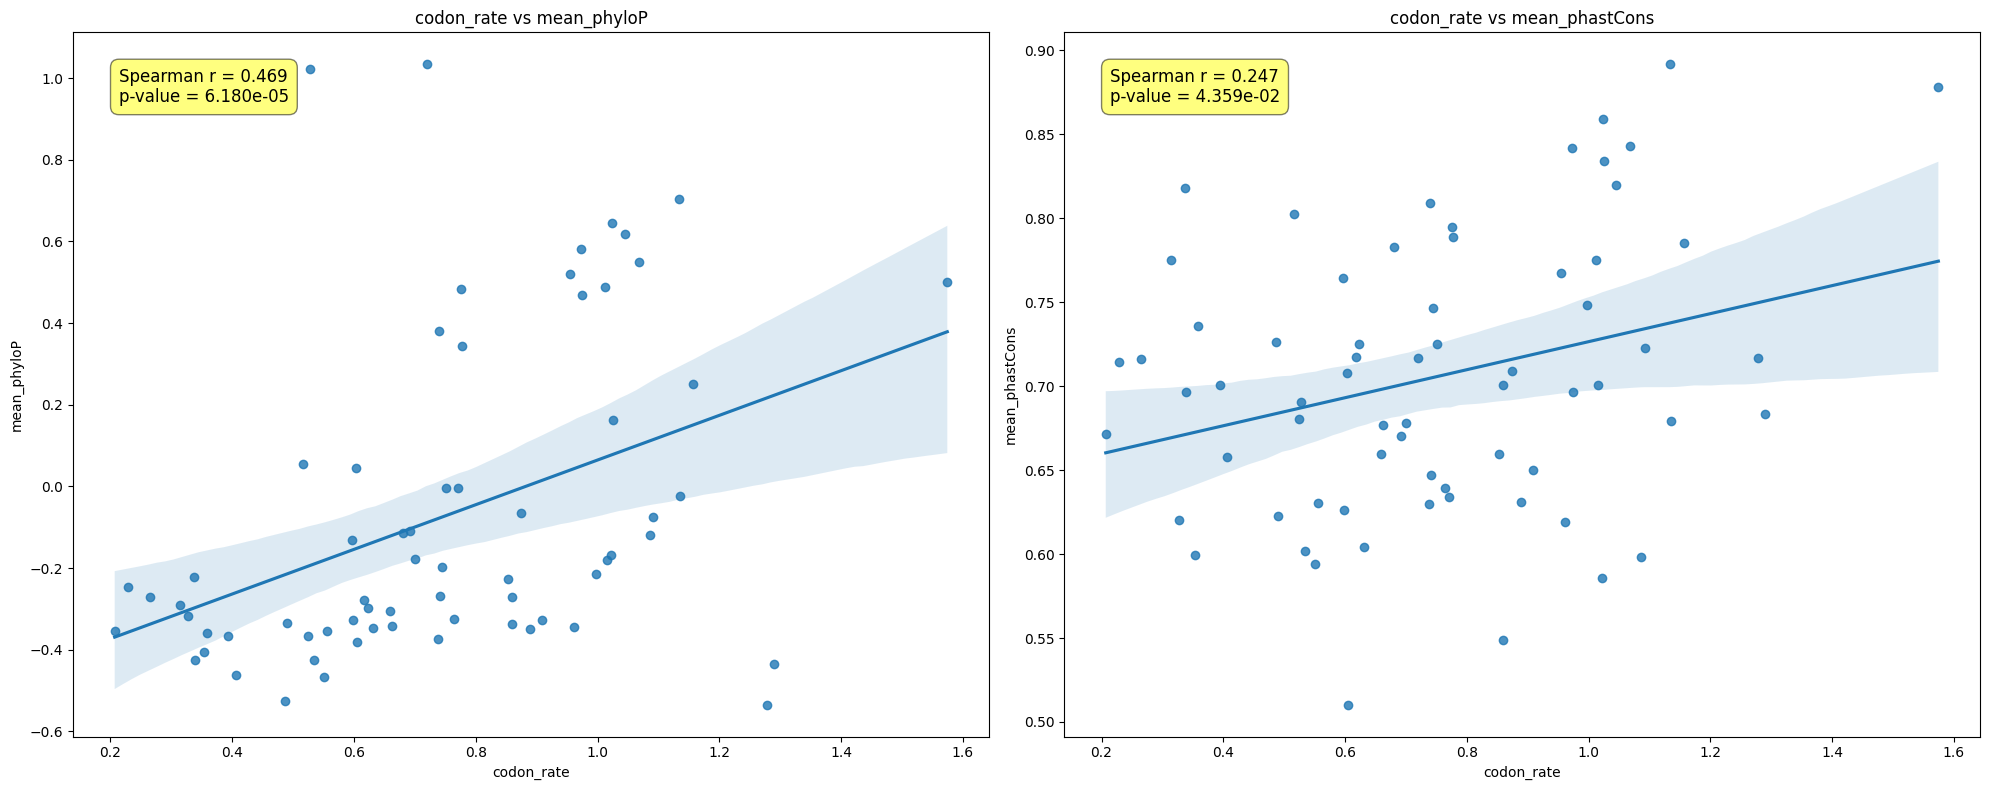

In [31]:
# Make correlation plots
dgrp2_correlation_synrev_results = plot_xvar_vs_yvars(dgrp2_synrev_medians_df, xvar_col='codon_rate', y1var_col='mean_phyloP', y2var_col='mean_phastCons', name='dgrp2')

dpgp3_correlation_synrev_results = plot_xvar_vs_yvars(dpgp3_synrev_medians_df, xvar_col='codon_rate', y1var_col='mean_phyloP', y2var_col='mean_phastCons', name='dpgp3')